Работу выполнил Данил Исламов (Stepik ID: 274397404)

<h1 align="left"> Image Captioning </h1>

![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели картинку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всего работают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерировать тексты с описанием.

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания (токенизация и проч.).
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса. 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Найти другой датасет (в MSCOCO видны паттерны — все тексты выглядят как "кто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети
4. Написать бота
5. Whatever comes to your head

## Базовая часть

In [ ]:
import numpy as np
import json
import random
import collections

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.legacy.data import Field

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import corpus_bleu

%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

### 1. Предобработка текстов из датасета

Загружаем датасет

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xf /content/drive/MyDrive/DLS_part2/DLS_Image_Captioning_project/handout.tar

In [ ]:
img_codes = np.load("data/image_codes.npy")
captions = np.array(json.load(open('data/captions_tokenized.json')))

Посмотрим на данные и на их размерность

In [ ]:
print(f'Image code shape: {img_codes.shape}')
print(f'Captions shape: {captions.shape}\n')
print(f'Image code example: \n{img_codes[0]}\n')
print(f'Captions example: \n{captions[0]}')

Image code shape: (118287, 2048)
Captions shape: (118287, 5)

Image code example: 
[0.3659946  0.2016555  0.9245725  ... 0.00344942 0.99817497 1.1091837 ]

Captions example: 
['people shopping in an open market for vegetables .'
 'an open market full of people and piles of vegetables .'
 'people are shopping at an open air produce market .'
 'large piles of carrots and potatoes at a crowded outdoor market .'
 'people shop for vegetables like carrots and potatoes at an open air market .']


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены к нижнему регистру. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречаемости каждого слова из словаря и оставить только те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлых занятиях. Батч должен выглядеть примерно так:



> [[1, 525, 8955, 5392, 9640, 4713, 7470, 525, 7341, 2296, 7696, 2, 3, 3, 3, 3, 3, 3, 3],
   
> [1, 525, 8955, 6784, 3557, 525, 7341, 2296, 2, 3, 3, 3, 3,  3, 3, 3, 3, 3, 3],

> [1, 525, 8955, 9209, 3557, 5486, 8335, 3071, 2296, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3],

> [1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696, 2, 3, 3, 3, 3, 3, 3, 3],

> [1, 525, 8955, 6784, 3557, 525, 7341, 6919, 2919, 6292, 250, 393, 525, 4618, 8335, 6292, 7882, 7696, 2]]  ;
         
> то есть короткие предложения дополняются PAD символами, слишком длинные обрезаются. В начале и в конце предложений добавляются символы начала и конца соответственно.

> ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке случайно выбиралось одно из ее описаний. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)

5. Поделить выборку на train/test


Токенизируем описания — разбиваем на слова, убираем точки в конце, добавляем символы начала и конца предложения.

In [ ]:
tokens = [[] for _ in range(len(captions))]
for i, descrs in enumerate(captions):
    tokens[i] = [['<sos>'] + sent.rstrip('.').split() + ['<eos>'] for sent in descrs]

Формируем словарь, чтобы закодировать описания.

In [ ]:
TEXT = Field(sequential=False,
             init_token='<sos>', 
             eos_token='<eos>',
             pad_token='<pad>')

words = [sent.rstrip('.').split() for sent in captions.reshape(-1)]
TEXT.build_vocab(words, min_freq=5)

Меняем токены на их код в словаре.

In [ ]:
for i, capt in enumerate(tokens):
    for j, sent in enumerate(capt):
        for k, word in enumerate(sent):
            tokens[i][j][k] = TEXT.vocab.stoi[word]

Разбиваем выборку на тренировочную и тестовую, реализуем "удобный" для данной задачи даталоадер

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_codes, tokens, test_size=0.2)

In [ ]:
class ImageCaptionsDataLoader:
    def __init__(self, img_codes, tokens, batch_size, device):
        self.data = list(zip(img_codes, tokens))
        self.batch_size = batch_size
        self.batches_count = int(np.ceil(len(self.data) / batch_size))
        self.device = device

    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.random.shuffle(np.arange(len(self.data)))
        
        for i in range(0, len(self.data), self.batch_size):
            input = self.data[i:i+self.batch_size]
            
            code = [sample[0] for sample in input]
            # Случайно выбираем по одному варианту описания для каждой картинки
            capt = [sample[1][np.random.randint(low=0, high=len(sample[1])-1)] for sample in input]
            
            max_length = max(list(map(len, capt)))
            for c in capt:
                c += [TEXT.vocab.stoi['<pad>']] * (max_length - len(c))

            yield (torch.tensor(code), torch.tensor(capt))

In [ ]:
train_loader = ImageCaptionsDataLoader(X_train, y_train, 128, device)
test_loader = ImageCaptionsDataLoader(X_test, y_test, 128, device)

### 2. Архитектура RNN




Основой для значительной части кода архитектуры послужили наработки из [домашнего задания по нейросетевому переводу](https://colab.research.google.com/drive/1R5Q_91i_45TIu29P-hbZCvfdrSnnmeZz?usp=sharing).

In [ ]:
class CaptionNet(nn.Module):
    def __init__(self, cnn_feature_dim, output_dim, emb_dim, hid_dim, n_layers, 
                 dropout, bidirectional):
        
        super(self.__class__, self).__init__()
        
        self.n_directions = int(bidirectional) + 1
        self.n_layers = n_layers
        self.hid_dim = hid_dim
        self.output_dim = output_dim

        self.init_hidden = nn.Linear(cnn_feature_dim,
                                     self.n_directions * n_layers * hid_dim)
        self.init_cell = nn.Linear(cnn_feature_dim,
                                     self.n_directions * n_layers * hid_dim)

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.image_embedding = nn.Linear(cnn_feature_dim, emb_dim)

        self.rnn = nn.LSTM(input_size=emb_dim*2,
                          hidden_size=hid_dim,
                          num_layers=n_layers,
                          batch_first=True,
                          dropout=dropout,
                          bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hid_dim * self.n_directions, output_dim)


    def forward(self, image_vectors, captions_ix, teacher_forcing):
        
        # Инициализируем hidden и cell состояния LSTM на основе векторов картинок
        h = self.init_hidden(image_vectors).reshape(self.n_directions * self.n_layers, 
                                                    len(image_vectors),
                                                    self.hid_dim)
        c = self.init_cell(image_vectors).reshape(self.n_directions * self.n_layers, 
                                                    len(image_vectors),
                                                    self.hid_dim)
        
        # Получаем эмбеддинги описаний
        embedded_words = self.embedding(captions_ix)

        # Получаем "эмбеддинги" векторов картинок и приводим их к размерности
        # эмбеддингов описаний
        embedded_img = torch.cat([self.image_embedding(image_vectors).unsqueeze(1)] * 
                                 embedded_words.shape[1], dim=1)

        # Конкатенируем эмбеддинги описаний и эмбеддинги картинок
        embedded = torch.cat([embedded_words, embedded_img], dim=-1)
        
        # Массив для хранения выходов модели
        outputs = torch.zeros(*captions_ix.shape, self.n_directions*self.hid_dim).to(device)

        # Изначально подаём на вход эмбеддинги токенов начала предложения, 
        # сконкатенированные с эмбеддингами картинок
        inp = embedded[:, 0].unsqueeze(1)
        
        # Последовательно генерируем описания
        for t in range(captions_ix.shape[1]):
            output, (h, c) = self.rnn(inp, (h, c))
            outputs[:, t] = output[:, 0]

            teacher_force = np.random.random() < teacher_forcing
            
            if t < (captions_ix.shape[1] - 1):
                if not teacher_force:
                    inp = self.embedding(output[:, 0].argmax(-1))
                    inp = torch.cat([inp, embedded_img[:, 0]], dim=-1).unsqueeze(1)
                else:
                    inp = embedded[:, t+1].unsqueeze(1)
        
        logits = self.fc(outputs)
        
        return logits        


    def predict(self, image, max_len):
        
        h = self.init_hidden(image).reshape(self.n_directions * self.n_layers, 
                                                    len(image),
                                                    self.hid_dim)
        c = self.init_cell(image).reshape(self.n_directions * self.n_layers, 
                                                    len(image),
                                                    self.hid_dim)

        captions_ix = torch.zeros((1, max_len), dtype=torch.long, device=device)
        captions_ix[:, 0] = TEXT.vocab.stoi['<sos>']

        embedded_words = self.embedding(captions_ix)

        embedded_img = torch.cat([self.image_embedding(image).unsqueeze(1)] * 
                                 embedded_words.shape[1], dim=1)

        embedded = torch.cat([embedded_words, embedded_img], dim=-1)
        
        outputs = torch.zeros(*captions_ix.shape, self.n_directions*self.hid_dim).to(device)

        inp = embedded[:, 0].unsqueeze(1)
        
        for t in range(captions_ix.shape[1]):
            output, (h, c) = self.rnn(inp, (h, c))
            outputs[:, t] = output[:, 0]
            
            inp = self.embedding(output[:, 0].argmax(-1))
            inp = torch.cat([inp, embedded_img[:, 0]], dim=-1).unsqueeze(1)
        
        logits = self.fc(outputs)
        
        return logits

### 3. Обучение

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х тактов тренировки считаем лосс на валидационной части.

#### Вспомогательные функции

Как и архитектура сети, код данных функций базируется на домашней работе по нейросетевому переводу.

In [ ]:
# Основная функция тренировки
def epoch_training(model, train_data, valid_data, criterion, optimizer, 
                   num_epochs):
    
    train_history = []
    valid_history = []
    bleu_history = []

    best_valid_loss = float('inf')
    best_bleu = -float('inf')

    for e in range(num_epochs):
               
        model.train()
        train_loss = 0
        history = []
        
        for batch in tqdm(train_data):

            optimizer.zero_grad()

            inp, targ = batch

            outp = model(inp.to(device), targ.to(device), 0.5)
            
            # Считаем лосс только по значащей части предложения:
            # обрезаем стартовый токен у target и последний токен 
            # у output
            outp = outp[:, :-1].reshape(-1, outp.size(-1))
            targ = targ[:, 1:].reshape(-1).to(device)

            loss = criterion(outp, targ)
            train_loss += loss.item()
            history.append(loss.item())
            
            loss.backward()
            optimizer.step()

        train_history.append(train_loss / len(train_data))  

        model.eval()
        
        original_text = []
        generated_text = []
        valid_loss = 0

        with torch.no_grad():
            
            for batch in valid_data:
                
                inp, targ = batch
                inp.to(device)
                
                outp = model(inp.to(device), targ.to(device), 0)
                
                original_text.extend([get_text(x, TEXT) for x in targ.cpu().numpy()])
                generated_text.extend([get_text(x, TEXT) 
                                        for x in outp[:, :-1].argmax(-1).detach().cpu().numpy()])
                
                outp = outp[:, :-1].reshape(-1, outp.size(-1))
                targ = targ[:, 1:].reshape(-1).to(device)

                loss = criterion(outp, targ)
                valid_loss += loss.item()

        valid_history.append(valid_loss / len(valid_data))
        bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
        bleu_history.append(bleu)

        if bleu > best_bleu:
            best_bleu = bleu
            torch.save(model.state_dict(), f'best_{type(model).__name__}_by_bleu.pt')
        
        if (valid_loss / len(valid_data)) < best_valid_loss:
            best_valid_loss = (valid_loss / len(valid_data))
            torch.save(model.state_dict(), f'best_{type(model).__name__}_by_valid_loss.pt')

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
        clear_output(True)
        ax[0].plot(history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        ax[0].legend()

        ax[1].plot(train_history, label='general train history')        
        ax[1].plot(valid_history, label='general valid history')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()

        ax[2].plot(bleu_history, label='valid bleu history')
        ax[2].set_xlabel('Epoch')
        ax[2].legend()

        plt.show()

        print(f"Train Loss: {train_loss / len(train_data)}")
        print(f"Valid Loss: {valid_loss / len(valid_data)}")
        print(f"Valid BLEU: {bleu}")

In [ ]:
# Функция для подсчёта лосса (непосредственно в обучении не используется)
def compute_loss(network, image_vectors, captions_ix, teacher_force: float):
    
    assert isinstance(image_vectors, np.ndarray) or torch.is_tensor(image_vectors), \
    "Image vectors should be either numpy arrays or torch tensors"
    assert isinstance(captions_ix, np.ndarray) or torch.is_tensor(captions_ix), \
    "Captions should be either numpy arrays or torch tensors"
    
    assert len(image_vectors.shape) in [1, 2], \
    "Image vectors' shape should be either [batch_size, image_code_dim] or [image_code_dim]"

    assert len(captions_ix.shape) in [1, 2], \
    "Captions' shape should be either [batch_size, seq_len] or [seq_len]"

    if isinstance(image_vectors, np.ndarray):
        image_vectors = torch.tensor(image_vectors)
    if isinstance(captions_ix, np.ndarray):
        captions_ix = torch.tensor(captions_ix)

    if len(image_vectors.shape) == 1:
        image_vectors = image_vectors.unsqueeze(0)
    if len(captions_ix.shape) == 1:
        captions_ix = captions_ix.unsqueeze(0)

    outp = network(image_vectors.to(device), captions_ix.to(device), teacher_force)
    outp = outp[:, :-1].reshape(-1, outp.size(-1))
    captions_ix = captions_ix[:, 1:].reshape(-1).to(device)
    
    loss_func = nn.CrossEntropyLoss(ignore_index=TEXT.vocab.stoi['<pad>'])
    loss = loss_func(outp, captions_ix).item()
    
    return loss

In [ ]:
# Вспомогательные функции для подсчёта BLEU
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>', '<eos>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

def get_text(x, vocab_field):
    generated = remove_tech_tokens(cut_on_eos([vocab_field.vocab.itos[elem] for elem in list(x)]))
    return generated

#### Обучение

Как показали результаты предыдущих домашних работ, качество модели не всегда однозначно определяется величиной лосса, поэтому при обучении будем отбирать 3 модели:

1.   Лучшую по валидационному лоссу
2.   Лучшую по величине BLEU на валидационной части датасета
3.   Лучшую по тренировочному лоссу (фактически, просто последние параметры, полученные при обучении)



При инициализациях моделей буду использовать те гиперпараметры, с которыми мне удалось добиться лучших показателей в проведённых экспериментах.

In [ ]:
network = CaptionNet(cnn_feature_dim=2048, output_dim=len(TEXT.vocab.itos), 
                     emb_dim=256, hid_dim=512, n_layers=5, 
                     dropout=0.3, bidirectional=True).to(device)

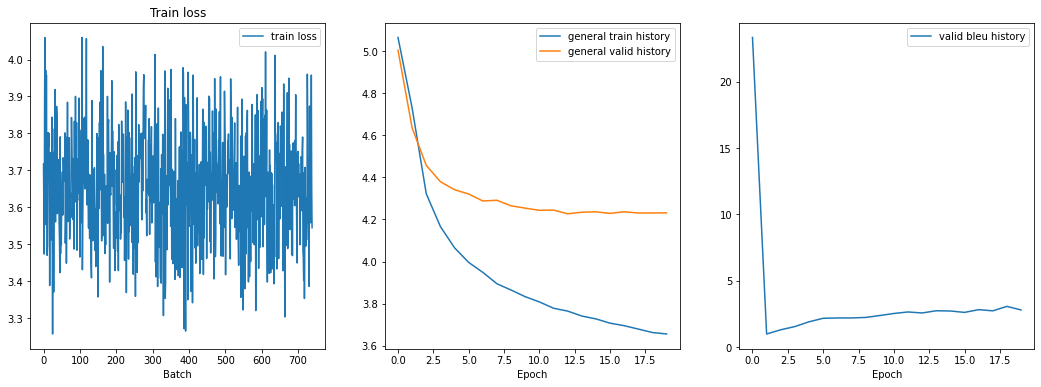

Train Loss: 3.655800786211684
Valid Loss: 4.231190062857963
Valid BLEU: 2.792022681359681


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=TEXT.vocab.stoi['<pad>'])
optimizer = torch.optim.Adam(network.parameters())

epoch_training(network, train_loader, test_loader, criterion, optimizer, 20)

In [ ]:
torch.save(network.state_dict, f'best_{type(network).__name__}_by_train_loss.pt')

#### Тестирование на картинке из тренировочного датасета

Проверим, что на тренировочных данных модель выдаёт что-то хоть отдалённо напоминающее желаемый результат, а также выберем, какие параметры лучше использовать

In [ ]:
inp, targ = list(train_loader)[40]

In [ ]:
# Модель в конце обучения
network.load_state_dict(torch.load(f'best_{type(network).__name__}_by_train_loss.pt'))

inp = inp[0].unsqueeze(0).to(device)
                
outp = network.predict(inp.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT.vocab.itos[word] for word in targ[0]])

['a', 'cat', 'is', 'in', 'a', 'a', 'a', 'a', 'a', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']
['<sos>', 'a', 'man', 'reflected', 'in', 'a', 'mirror', 'looking', 'at', 'a', 'cat', 'sitting', 'the', 'window', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


In [ ]:
# Лучшая модель по валидационному лоссу
network.load_state_dict(torch.load(f'best_{type(network).__name__}_by_valid_loss.pt'))

inp = inp[0].unsqueeze(0).to(device)
                
outp = network.predict(inp.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT.vocab.itos[word] for word in targ[0]])

['a', 'cat', 'is', 'a', 'a', 'a', 'a', 'a', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', 'a', 'the', 'the', 'the', 'the', 'the', 'the']
['<sos>', 'a', 'man', 'reflected', 'in', 'a', 'mirror', 'looking', 'at', 'a', 'cat', 'sitting', 'the', 'window', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


In [ ]:
# Лучшая модель по BLEU
network.load_state_dict(torch.load(f'best_{type(network).__name__}_by_bleu.pt'))

inp = inp[0].unsqueeze(0).to(device)
                
outp = network.predict(inp.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT.vocab.itos[word] for word in targ[0]])

['a', 'man', 'of', 'a', 'a', 'a', 'a', 'a', 'a', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']
['<sos>', 'a', 'man', 'reflected', 'in', 'a', 'mirror', 'looking', 'at', 'a', 'cat', 'sitting', 'the', 'window', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


### 4. Inception и генерация описаний


Загрузим предобученную Inception v3, соберём модель в единое целое и протестируем её на новых картинках.

In [ ]:
%cd /content/drive/MyDrive/DLS_part2/DLS_Image_Captioning_project

from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

%cd /content/

/content/drive/MyDrive/DLS_part2/DLS_Image_Captioning_project


/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


/content


In [ ]:
def generate_caption(model, image, max_len=30):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        vectors_8x8, vectors_neck, logits = inception(image[None])
        
        outp = model.predict(vectors_neck.to(device), max_len)

    caption = [TEXT.vocab.itos[word] for word in outp.argmax(-1)[0]]
    
    for i, word in enumerate(caption):
        if word == '<eos>':
            caption = caption[:i]
            break
    
    return caption

Скачаем пару картинок, чтобы проверить качество. Для начала опробуем модель, лучшую по тренировочному лоссу.

In [ ]:
network.load_state_dict(torch.load(f'best_{type(network).__name__}_by_train_loss.pt'))

<All keys matched successfully>

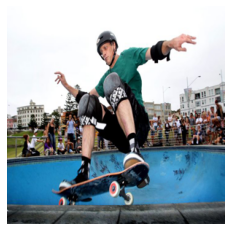


a man riding is a a a a a.


In [ ]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

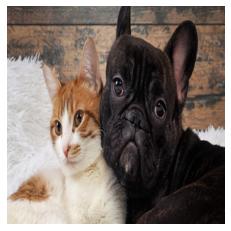


a cat is a a a a a.


In [ ]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

## Demo

Теперь найдём несколько новых картинок, применим к ним сетку и посмотрим, что получится.

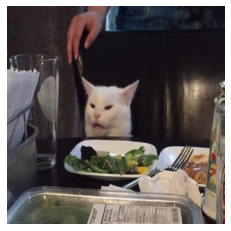


a plate of with a a a a.




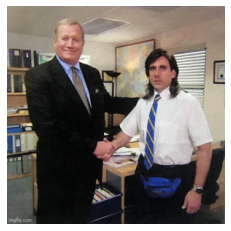


a man in a a a a a.




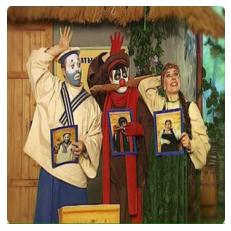


a group of with a a a a.




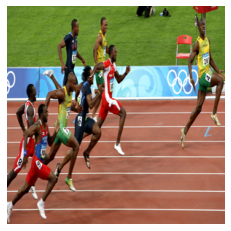


a group of a a a a a.




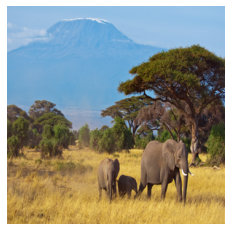


a elephant of elephants in in a a.




In [ ]:
# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

Теперь протестируем на тех же картинках модель, оказавшуюся лучшей по валидационному лоссу.

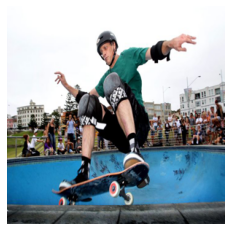


a man riding is riding a the on a.




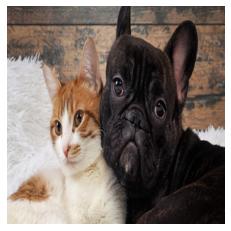


a cat and on a a a a.




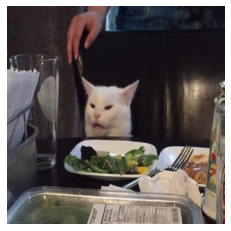


a plate of a a a a a.




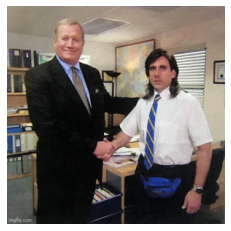


a man in a a a a a a.




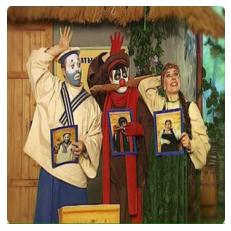


a man of a a a a a.




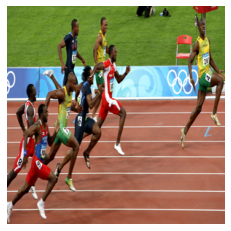


a tennis of a tennis a a a.




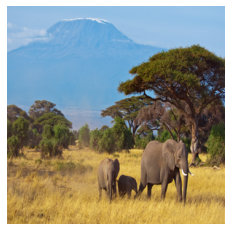


a elephant elephant elephants in in a a.




In [ ]:
network.load_state_dict(torch.load(f'best_{type(network).__name__}_by_valid_loss.pt'))

# skateboarder
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# cat and dog
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

И, наконец, модель, лучшую по BLEU

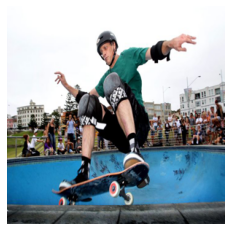


a man of a a a a a a.




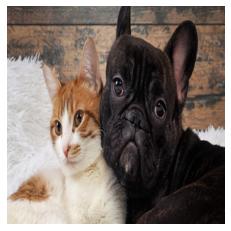


a man of a a a a a.




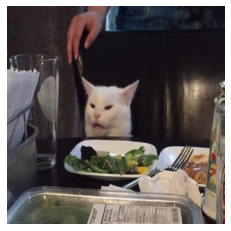


a man of a a a a a a.




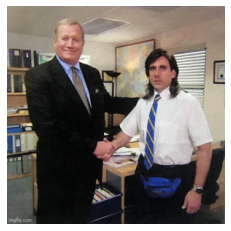


a man of a a a a a a.




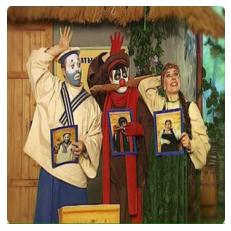


a man of a a a a a a.




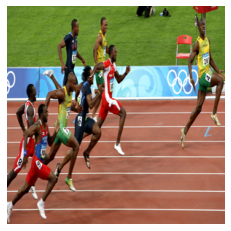


a man of a a a a a.




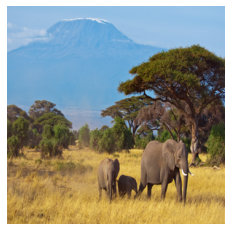


a man of a a a a a.




In [ ]:
network.load_state_dict(torch.load(f'best_{type(network).__name__}_by_bleu.pt'))

# skateboarder
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# cat and dog
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network, img)
print(' '.join(caption) + '.')

print('\n')

Можно заметить, что модель, оказавшаяся лучшей по BLEU, одновременно является и самой плохой по качеству описаний — её предсказания оказались идентичными для всех тестовых картинок. Возможно это связано с тем, что самый высокий показатель BLEU был каким-то образом достигнут на первой же эпохе, когда модель ещё была совсем не обучена. Что касается же оставшихся двух моделей, видно, что они обе показали довольно низкое качество, хоть и научились извлекать определённую информацию из векторов картинок, а также "запомнили" примерную структуру описаний из датасета. Выбрать из данных двух моделей лучшую весьма затруднительно, поскольку продемонстрированные результаты кажутся схожими.

## Вариативная часть

### Self-Attention

Реализуем self-attention по аналогии с тем, который используется в GPT, и добавим его к базовой модели.

#### Архитектура

In [ ]:
class CaptionNetWithSelfAttention(nn.Module):
    def __init__(self, cnn_feature_dim, output_dim, emb_dim, hid_dim, n_layers, 
                 dropout, bidirectional, attn_heads):
        
        super(self.__class__, self).__init__()

        self.n_directions = int(bidirectional) + 1
        self.n_layers = n_layers
        self.hid_dim = hid_dim
        self.output_dim = output_dim

        self.init_hidden = nn.Linear(cnn_feature_dim,
                                     self.n_directions * n_layers * hid_dim)
        self.init_cell = nn.Linear(cnn_feature_dim,
                                     self.n_directions * n_layers * hid_dim)

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.image_embedding = nn.Linear(cnn_feature_dim, emb_dim)

        self.rnn = nn.LSTM(input_size=emb_dim*3,
                          hidden_size=hid_dim,
                          num_layers=n_layers,
                          batch_first=True,
                          dropout=dropout,
                          bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hid_dim * self.n_directions, output_dim)

        self.query = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.value = nn.Linear(emb_dim, emb_dim)

        self.attention = nn.MultiheadAttention(emb_dim, attn_heads, dropout=dropout,
                                               batch_first=True)


    def forward(self, image_vectors, captions_ix, teacher_forcing):
        
        h = self.init_hidden(image_vectors).reshape(self.n_directions * self.n_layers, 
                                                    len(image_vectors),
                                                    self.hid_dim)
        c = self.init_cell(image_vectors).reshape(self.n_directions * self.n_layers, 
                                                    len(image_vectors),
                                                    self.hid_dim)
        
        embedded_words = self.embedding(captions_ix)

        embedded_img = torch.cat([self.image_embedding(image_vectors).unsqueeze(1)] * 
                                 embedded_words.shape[1], dim=1)

        embedded = torch.cat([embedded_words, embedded_img], dim=-1)
        
        outputs = torch.zeros(*captions_ix.shape, self.n_directions*self.hid_dim).to(device)

        # Массив для хранения сгенерированных слов
        seen = torch.zeros(*embedded_words.shape).to(device)
        seen[:, 0] = embedded_words[:, 0]

        inp = embedded[:, 0].unsqueeze(1)
        
        for t in range(captions_ix.shape[1]):
           
            # Получаем матрицы query, key и value согласно уже имеющимся частям 
            # предложений
            Q = self.query(seen[:, t].clone().to(device)).unsqueeze(1)
            K = self.key(seen[:, :t+1])
            V = self.value(seen[:, :t+1])
            # Вычисляем attention
            attn_outp, _ = self.attention(Q, K, V)
            
            output, (h, c) = self.rnn(torch.cat([inp, attn_outp], dim=-1), (h, c))
            outputs[:, t] = output[:, 0]

            teacher_force = np.random.random() < teacher_forcing
            
            if t < (captions_ix.shape[1] - 1):
                if not teacher_force:
                    inp = self.embedding(output[:, 0].argmax(-1))
                    seen[:, t+1] = inp
                    inp = torch.cat([inp, embedded_img[:, 0]], dim=-1).unsqueeze(1)
                else:
                    inp = embedded[:, t+1].unsqueeze(1)
                    seen[:, t+1] = embedded_words[:, t+1]           
        
        logits = self.fc(outputs)
        
        return logits        

    def predict(self, image, max_len):
        
        h = self.init_hidden(image).reshape(self.n_directions * self.n_layers, 
                                                    len(image),
                                                    self.hid_dim)
        c = self.init_cell(image).reshape(self.n_directions * self.n_layers, 
                                                    len(image),
                                                    self.hid_dim)

        captions_ix = torch.zeros((1, max_len), dtype=torch.long, device=device)
        captions_ix[:, 0] = TEXT.vocab.stoi['<sos>']

        embedded_words = self.embedding(captions_ix)

        embedded_img = torch.cat([self.image_embedding(image).unsqueeze(1)] * 
                                 embedded_words.shape[1], dim=1)

        embedded = torch.cat([embedded_words, embedded_img], dim=-1)
        
        outputs = torch.zeros(*captions_ix.shape, self.n_directions*self.hid_dim).to(device)

        seen = torch.zeros(*embedded_words.shape).to(device)
        seen[:, 0] = embedded_words[:, 0]

        inp = embedded[:, 0].unsqueeze(1)
        
        for t in range(captions_ix.shape[1]):
            
            Q = self.query(seen[:, t].clone().to(device)).unsqueeze(1)
            K = self.key(seen[:, :t+1])
            V = self.value(seen[:, :t+1])

            attn_outp, _ = self.attention(Q, K, V)
            
            output, (h, c) = self.rnn(torch.cat([inp, attn_outp], dim=-1), (h, c))
            outputs[:, t] = output[:, 0]
            
            inp = self.embedding(output[:, 0].argmax(-1))
            if t+1 < captions_ix.shape[1]:     
                seen[:, t+1] = inp
            inp = torch.cat([inp, embedded_img[:, 0]], dim=-1).unsqueeze(1)
        
        logits = self.fc(outputs)
        
        return logits

#### Обучение

In [ ]:
network2 = CaptionNetWithSelfAttention(cnn_feature_dim=2048, output_dim=len(TEXT.vocab.itos), 
                     emb_dim=256, hid_dim=512, n_layers=3, 
                     dropout=0.3, bidirectional=True,
                     attn_heads=8).to(device)

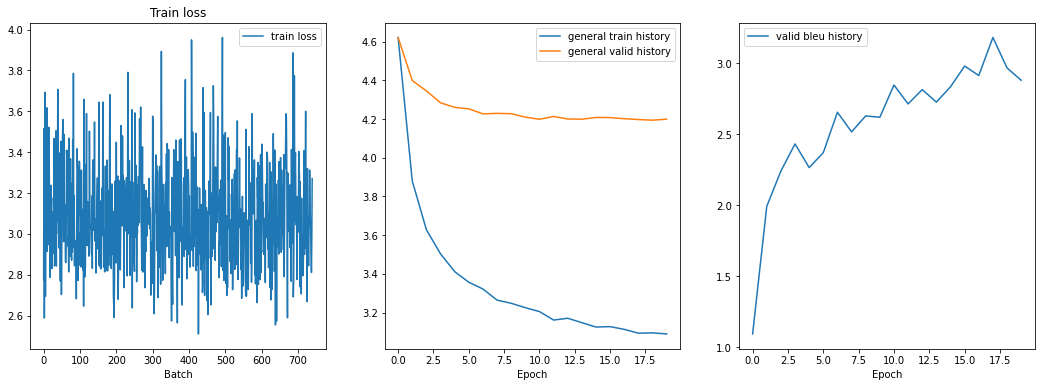

Train Loss: 3.0896615199140602
Valid Loss: 4.1992907730308735
Valid BLEU: 2.881643169582105


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=TEXT.vocab.stoi['<pad>'])
optimizer = torch.optim.Adam(network2.parameters())

epoch_training(network2, train_loader, test_loader, criterion, optimizer, 20)

In [ ]:
torch.save(network2.state_dict(), f'best_{type(network2).__name__}_by_train_loss.pt')

#### Тестирование

##### На картинке из тренировочного датасета

In [ ]:
inp, targ = list(train_loader)[10]

In [ ]:
# Модель в конце обучения
network2.load_state_dict(torch.load(f'best_{type(network2).__name__}_by_train_loss.pt'))

inp = inp[0].unsqueeze(0).to(device)
                
outp = network2.predict(inp.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT.vocab.itos[word] for word in targ[0]])

['a', 'woman', 'flying', 'a', 'a', 'a', 'a', 'a', 'a', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']
['<sos>', 'a', 'person', 'preparing', 'to', 'fly', 'a', 'large', 'kite', 'in', 'a', 'field', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


In [ ]:
# Лучшая модель по валидационному лоссу
network2.load_state_dict(torch.load(f'best_{type(network2).__name__}_by_valid_loss.pt'))

inp = inp[0].unsqueeze(0).to(device)
                
outp = network2.predict(inp.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT.vocab.itos[word] for word in targ[0]])

['a', 'man', 'flying', 'a', 'kite', 'kite', 'kite', 'kite', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']
['<sos>', 'a', 'person', 'preparing', 'to', 'fly', 'a', 'large', 'kite', 'in', 'a', 'field', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


In [ ]:
# Лучшая модель по BLEU
network2.load_state_dict(torch.load(f'best_{type(network2).__name__}_by_bleu.pt'))

inp = inp[0].unsqueeze(0).to(device)
                
outp = network2.predict(inp.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT.vocab.itos[word] for word in targ[0]])

['a', 'person', 'flying', 'a', 'kite', 'kite', 'a', 'kite', 'kite', 'kite', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']
['<sos>', 'a', 'person', 'preparing', 'to', 'fly', 'a', 'large', 'kite', 'in', 'a', 'field', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


##### На новых картинках

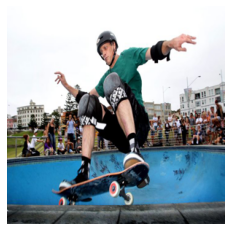


a man riding a skateboard on a a.




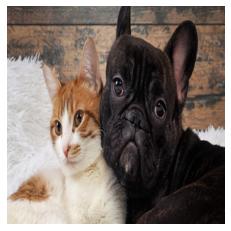


a dog and white a a a a.




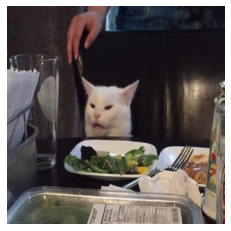


a cat of a a of a a.




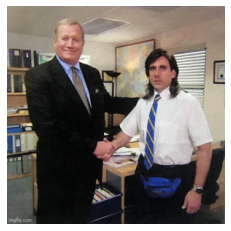


a man in a a a a a.




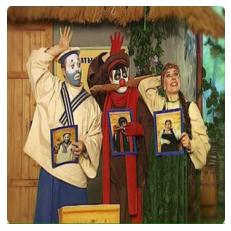


a group of a a a a a.




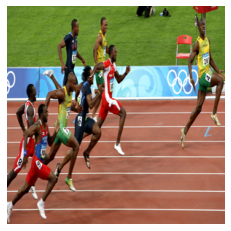


a group of a playing a a a.




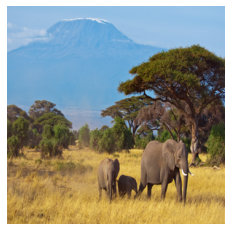


a elephants of elephants walking in a field.




In [ ]:
network2.load_state_dict(torch.load(f'best_{type(network2).__name__}_by_train_loss.pt'))

# skateboarder
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# cat and dog
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

    
# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

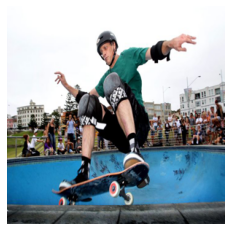


a skateboarder is a skateboard on a a a.




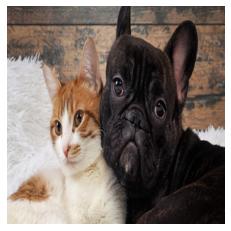


a cat and a a a a a a a a.




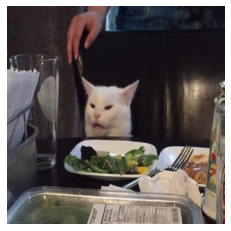


a plate of a a a a a a.




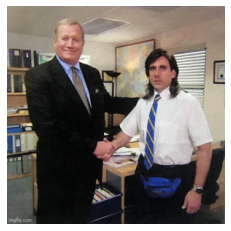


a man in a suit a a a a.




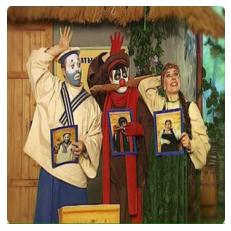


a group of a a a a a.




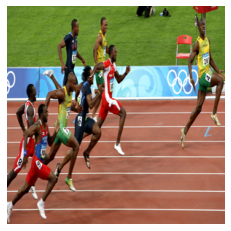


a group of a a a a a.




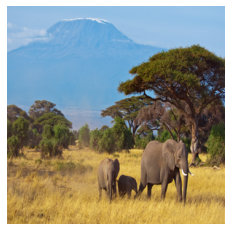


a elephants of elephants walking in a grass.




In [ ]:
network2.load_state_dict(torch.load(f'best_{type(network2).__name__}_by_valid_loss.pt'))

# skateboarder
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# cat and dog
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

    
# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

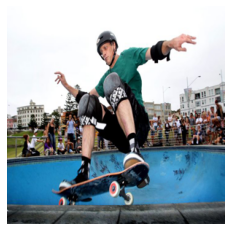


a man is a skateboard on a a.




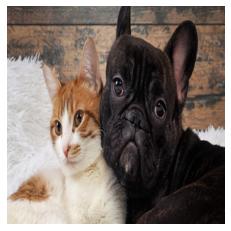


a cat and on on on a a.




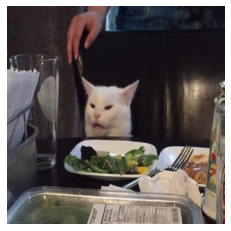


a plate of a a a a a.




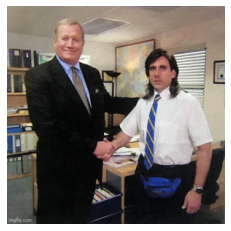


a man in a a a a a.




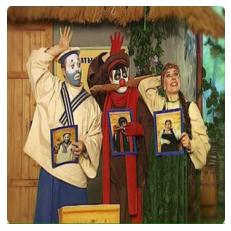


a group of a a a a a.




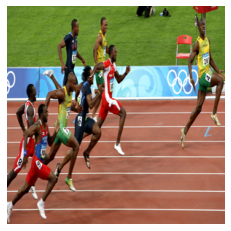


a group of a a a a a.




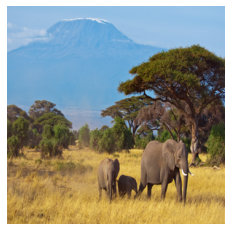


a elephants of elephants walking in a field.




In [ ]:
network2.load_state_dict(torch.load(f'best_{type(network2).__name__}_by_bleu.pt'))

# skateboarder
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# cat and dog
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

    
# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption(network2, img)
print(' '.join(caption) + '.')

print('\n')

Заметно, что на некоторых примерах качество значительно выросло по сравнению с базовой моделью — особенно ярко это проявляется на картинке с гуляющими слонами. Можно заключить, что self-attention, хоть и не сделал модель идеальной, но всё же помог ей генерировать более осмысленные описания. Разницы между показателями модели с тремя вариантами параметров почти не наблюдается.

### Visual Attention

Теперь попробуем добавить в исходную модель visual attention, по аналогии с описанным в статье [Image captioning with visual attention](https://www.tensorflow.org/tutorials/text/image_captioning).

#### Подготовка данных

In [ ]:
random.seed(158)

Скачиваем датасет. Код из следующей ячейки взят из статьи почти без изменений

In [ ]:
# Описания
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -O annotations.zip -q
!unzip -qq annotations.zip
!rm annotations.zip
# Картинки
!wget http://images.cocodataset.org/zips/train2014.zip -O train_images.zip -q
!unzip -qq train_images.zip
!rm train_images.zip

with open('/content/annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = (f"<sos> {val['caption'].rstrip('.')} <eos>").lower()
    image_path = '/content/train2014/' + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

image_paths = image_paths[:6000]

Собираем датасет

In [ ]:
image_dataset = {name: [capt.split() for capt in image_path_to_caption[name]] 
                 for name in image_paths}

In [ ]:
TEXT_2 = Field(sequential=False,
             init_token='<sos>', 
             eos_token='<eos>',
             pad_token='<pad>')

words_2 = [c for _, capt in image_dataset.items() for c in capt]
TEXT_2.build_vocab(words_2, min_freq=5)

In [ ]:
for key in image_dataset.keys():
    for i, capt in enumerate(image_dataset[key]):
        for j, word in enumerate(capt):
            image_dataset[key][i][j] = TEXT_2.vocab.stoi[word]

In [ ]:
images_id = list(image_dataset.keys())
random.shuffle(images_id)

train_size = int(0.8 * len(images_id))

train_image_paths = images_id[:train_size]
test_image_paths = images_id[train_size:]

In [ ]:
train_data = {path: image_dataset[path] for path in train_image_paths}
test_data = {path: image_dataset[path] for path in test_image_paths}

In [ ]:
class ImageCaptionsDataLoader_2:
    def __init__(self, data: dict, batch_size, device):
        self.data = list(data.items())
        self.batch_size = batch_size
        self.batches_count = int(np.ceil(len(self.data) / batch_size))
        self.device = device

    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.random.shuffle(np.arange(len(self.data)))
        
        for i in range(0, len(self.data), self.batch_size):
            input = self.data[i:i+self.batch_size]
            
            image = [self.preprocess_image(sample[0]) for sample in input]
            capt = [sample[1][np.random.randint(low=0, high=len(sample[1])-1)] for sample in input]

            max_length = max(list(map(len, capt)))
            for c in capt:
                c += [TEXT_2.vocab.stoi['<pad>']] * (max_length - len(c))

            yield (torch.tensor(image), torch.tensor(capt))

    def preprocess_image(self, image_path):
        img = Image.fromarray(plt.imread(image_path))
        img = np.array(img.resize((299, 299))).astype('float32') / 255.
        if len(img.shape) == 2:
            img = np.stack([img] * 3).transpose([1, 2, 0]) 
        img = img.transpose([2, 0, 1])
        return img

In [ ]:
train_loader = ImageCaptionsDataLoader_2(train_data, 128, device)
test_loader = ImageCaptionsDataLoader_2(test_data, 128, device)

#### Архитектура

Реализация класса BahdanauAttention также, почти без изменений, взята из статьи (адаптирована с tensorflow).

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, cnn_feature_dim, hid_dim, units):
        super().__init__()
        self.cnn_feature_dim = cnn_feature_dim
        self.W1 = nn.Linear(cnn_feature_dim, units)
        self.W2 = nn.Linear(hid_dim, units)
        self.V = nn.Linear(units, 1)

    def forward(self, features_8x8, hidden_state):

        features = features_8x8.reshape(features_8x8.size()[0], -1, self.cnn_feature_dim)

        hidden_with_time_axis = hidden_state[0].unsqueeze(1)

        attention_hidden_layer = torch.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis))

        score = self.V(attention_hidden_layer)

        attention_weights = F.softmax(score, dim=1)

        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights        

In [ ]:
class CaptionNetWithVisualAttention(nn.Module):
    def __init__(self, cnn_feature_dim, output_dim, emb_dim, hid_dim, n_layers, 
                 dropout, bidirectional, units):
        
        super(self.__class__, self).__init__()

        self.n_directions = int(bidirectional) + 1
        self.n_layers = n_layers
        self.hid_dim = hid_dim
        self.output_dim = output_dim

        self.init_hidden = nn.Linear(cnn_feature_dim,
                                     self.n_directions * n_layers * hid_dim)
        self.init_cell = nn.Linear(cnn_feature_dim,
                                     self.n_directions * n_layers * hid_dim)

        self.embedding = nn.Embedding(len(TEXT_2.vocab.itos), emb_dim)
        self.image_code_embedding = nn.Linear(cnn_feature_dim, emb_dim)
        self.image_features_embedding = nn.Linear(cnn_feature_dim, emb_dim)

        self.rnn = nn.LSTM(input_size=emb_dim*3,
                          hidden_size=hid_dim,
                          num_layers=n_layers,
                          batch_first=True,
                          dropout=dropout,
                          bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hid_dim * self.n_directions, output_dim)

        self.query = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.value = nn.Linear(emb_dim, emb_dim)

        self.attention = BahdanauAttention(cnn_feature_dim, hid_dim, units)


    def forward(self, image_features_8x8, image_vectors, captions_ix, teacher_forcing):
        
        h = self.init_hidden(image_vectors).reshape(self.n_directions * self.n_layers, 
                                                    len(image_vectors),
                                                    self.hid_dim)
        c = self.init_cell(image_vectors).reshape(self.n_directions * self.n_layers, 
                                                    len(image_vectors),
                                                    self.hid_dim)
        
        embedded_words = self.embedding(captions_ix)

        embedded_img = torch.cat([self.image_code_embedding(image_vectors).unsqueeze(1)] * 
                                 embedded_words.shape[1], dim=1)

        embedded = torch.cat([embedded_words, embedded_img], dim=-1)
        
        outputs = torch.zeros(*captions_ix.shape, self.n_directions*self.hid_dim).to(device)

        inp = embedded[:, 0].unsqueeze(1)
        
        for t in range(captions_ix.shape[1]):
            attn_outp, _ = self.attention(image_features_8x8, h)
            attn_outp = self.image_features_embedding(attn_outp)
            inp = torch.cat([inp, attn_outp.unsqueeze(1)], dim=-1)

            output, (h, c) = self.rnn(inp, (h, c))
            outputs[:, t] = output[:, 0]

            teacher_force = np.random.random() < teacher_forcing
            
            if t < (captions_ix.shape[1] - 1):
                if not teacher_force:
                    inp = self.embedding(output[:, 0].argmax(-1))
                    inp = torch.cat([inp, embedded_img[:, 0]], dim=-1).unsqueeze(1)
                else:
                    inp = embedded[:, t+1].unsqueeze(1)     
        
        logits = self.fc(outputs)
        
        return logits        

    def predict(self, image_features_8x8, image_vectors, max_len):
        
        h = self.init_hidden(image_vectors).reshape(self.n_directions * self.n_layers, 
                                                    len(image_vectors),
                                                    self.hid_dim)
        c = self.init_cell(image_vectors).reshape(self.n_directions * self.n_layers, 
                                                    len(image_vectors),
                                                    self.hid_dim)

        captions_ix = torch.zeros((1, max_len), dtype=torch.long, device=device)
        captions_ix[:, 0] = TEXT_2.vocab.stoi['<sos>']

        embedded_words = self.embedding(captions_ix)

        embedded_img = torch.cat([self.image_code_embedding(image_vectors).unsqueeze(1)] * 
                                 embedded_words.shape[1], dim=1)

        embedded = torch.cat([embedded_words, embedded_img], dim=-1)
        
        outputs = torch.zeros(*captions_ix.shape, self.n_directions*self.hid_dim).to(device)

        inp = embedded[:, 0].unsqueeze(1)
        
        for t in range(captions_ix.shape[1]):
            attn_outp, _ = self.attention(image_features_8x8, h)
            attn_outp = self.image_features_embedding(attn_outp)
            inp = torch.cat([inp, attn_outp.unsqueeze(1)], dim=-1)
            
            output, (h, c) = self.rnn(inp, (h, c))
            outputs[:, t] = output[:, 0]
            
            inp = self.embedding(output[:, 0].argmax(-1))
            inp = torch.cat([inp, embedded_img[:, 0]], dim=-1).unsqueeze(1)
        
        logits = self.fc(outputs)
        
        return logits

#### Обучение

In [ ]:
def epoch_training_2(encoder, decoder, train_data, valid_data, criterion, optimizer, 
                   num_epochs):
    
    train_history = []
    valid_history = []
    bleu_history = []

    best_valid_loss = float('inf')
    best_bleu = -float('inf')

    for e in range(num_epochs):
               
        decoder.train()
        train_loss = 0
        history = []
        
        for batch in tqdm(train_data):

            optimizer.zero_grad()

            inp, targ = batch

            with torch.no_grad():
                vectors_8x8, vectors_neck, logits = encoder(inp.to(device))
            
            outp = decoder(vectors_8x8.to(device), vectors_neck.to(device), 
                           targ.to(device), 0.5)
            outp = outp[:, :-1].reshape(-1, outp.size(-1))
            targ = targ[:, 1:].reshape(-1).to(device)

            loss = criterion(outp, targ)
            train_loss += loss.item()
            history.append(loss.item())
            
            loss.backward()
            optimizer.step()

        train_history.append(train_loss / len(train_data))  

        decoder.eval()
        
        original_text = []
        generated_text = []
        valid_loss = 0

        with torch.no_grad():
            
            for batch in valid_data:
                
                inp, targ = batch
                inp.to(device)
                
                vectors_8x8, vectors_neck, logits = encoder(inp.to(device))

                outp = decoder(vectors_8x8.to(device), vectors_neck.to(device), 
                           targ.to(device), 0)
                
                original_text.extend([get_text(x, TEXT_2) for x in targ.cpu().numpy()])
                generated_text.extend([get_text(x, TEXT_2) 
                                        for x in outp[:, :-1].argmax(-1).detach().cpu().numpy()])
                
                outp = outp[:, :-1].reshape(-1, outp.size(-1))
                targ = targ[:, 1:].reshape(-1).to(device)

                loss = criterion(outp, targ)
                valid_loss += loss.item()

        valid_history.append(valid_loss / len(valid_data))
        bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
        bleu_history.append(bleu)

        if bleu > best_bleu:
            best_bleu = bleu
            torch.save(decoder.state_dict(), f'best_{type(decoder).__name__}_by_bleu.pt')
        
        if (valid_loss / len(valid_data)) < best_valid_loss:
            best_valid_loss = (valid_loss / len(valid_data))
            torch.save(decoder.state_dict(), f'best_{type(decoder).__name__}_by_valid_loss.pt')

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
        clear_output(True)
        ax[0].plot(history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        ax[0].legend()

        ax[1].plot(train_history, label='general train history')        
        ax[1].plot(valid_history, label='general valid history')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()

        ax[2].plot(bleu_history, label='valid bleu history')
        ax[2].set_xlabel('Epoch')
        ax[2].legend()

        plt.show()

        print(f"Train Loss: {train_loss / len(train_data)}")
        print(f"Valid Loss: {valid_loss / len(valid_data)}")
        print(f"Valid BLEU: {bleu}")

In [ ]:
decoder = CaptionNetWithVisualAttention(cnn_feature_dim=2048, output_dim=len(TEXT_2.vocab.itos), 
                     emb_dim=256, hid_dim=512, n_layers=3, 
                     dropout=0.3, bidirectional=True, units=512).to(device)

inception = inception.to(device)                     

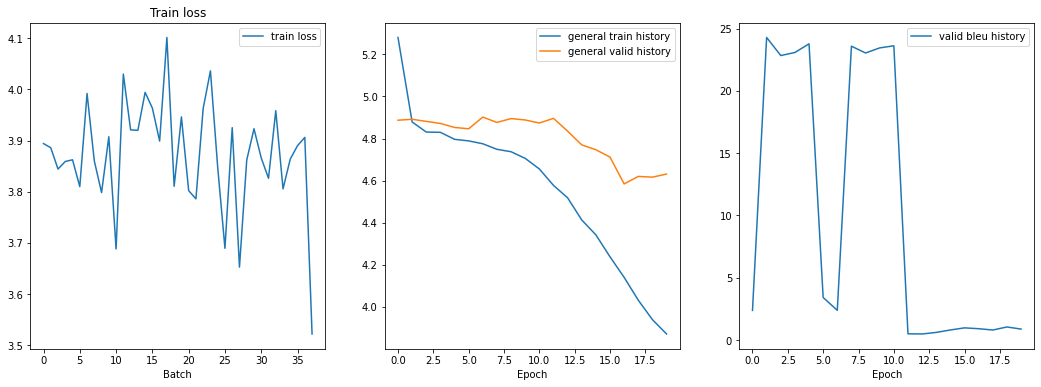

Train Loss: 3.871370873953167
Valid Loss: 4.6311009407043455
Valid BLEU: 0.8775129337942957


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=TEXT_2.vocab.stoi['<pad>'])
optimizer = torch.optim.Adam(decoder.parameters())

epoch_training_2(inception.to(device), decoder, train_loader, test_loader, criterion, optimizer, 20)

In [ ]:
torch.save(decoder.state_dict(), f'best_{type(decoder).__name__}_by_train_loss.pt')

После тестирования модели мне показалось, что она несколько недоучена, поэтому запускаем ещё на 20 эпох. Параметры после первых 20 эпох были сохранены, так что потери файлов из-за перезаписи не будет.

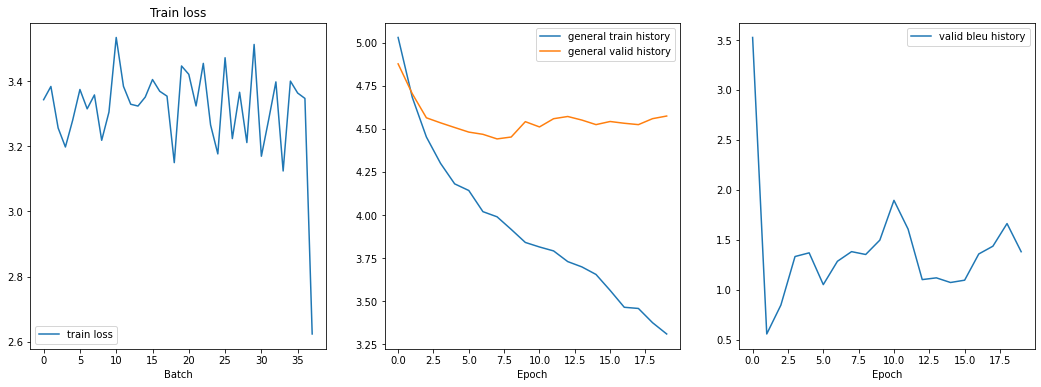

Train Loss: 3.3106797619869837
Valid Loss: 4.574019479751587
Valid BLEU: 1.3804531165573226


In [ ]:
decoder.load_state_dict(torch.load(f'best_{type(decoder).__name__}_by_train_loss.pt'))

criterion = nn.CrossEntropyLoss(ignore_index=TEXT_2.vocab.stoi['<pad>'])
optimizer = torch.optim.Adam(decoder.parameters()) # favourite one

epoch_training_2(inception.to(device), decoder, train_loader, test_loader, criterion, optimizer, 20)

Хоть на тренировочной части лосс и продолжает стремительно падать, на валидационной части он уже начал возрастать, поэтому остановимся на данном этапе.

In [ ]:
torch.save(decoder.state_dict(), f'best_{type(decoder).__name__}_by_train_loss.pt')

#### Тестирование

##### На картинке из тренировочного датасета

In [ ]:
for batch in train_loader:
    inp, targ = batch
    break
inp = inp[0].unsqueeze(0)
targ = targ[0].unsqueeze(0)

In [ ]:
# Модель в конце обучения
decoder.load_state_dict(torch.load(f'best_{type(decoder).__name__}_by_train_loss.pt'))

vectors_8x8, vectors_neck, logits = inception(inp.to(device))
outp = decoder.predict(vectors_8x8.to(device), vectors_neck.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT_2.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT_2.vocab.itos[word] for word in targ[0]])

['a', 'white', 'of', 'with', 'on', 'on', 'on', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']
['<sos>', 'a', 'bunch', 'of', 'pink', 'umbrellas', '<unk>', 'upside', 'down', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


In [ ]:
# Лучшая модель по валидационному лоссу
decoder.load_state_dict(torch.load(f'best_{type(decoder).__name__}_by_valid_loss.pt'))

vectors_8x8, vectors_neck, logits = inception(inp.to(device))
outp = decoder.predict(vectors_8x8.to(device), vectors_neck.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT_2.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT_2.vocab.itos[word] for word in targ[0]])

['a', 'of', 'of', 'of', 'on', 'on', 'a', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']
['<sos>', 'a', 'bunch', 'of', 'pink', 'umbrellas', '<unk>', 'upside', 'down', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


In [ ]:
# Лучшая модель по BLEU
decoder.load_state_dict(torch.load(f'best_{type(decoder).__name__}_by_bleu.pt'))

vectors_8x8, vectors_neck, logits = inception(inp.to(device))
outp = decoder.predict(vectors_8x8.to(device), vectors_neck.to(device), 30)

for i in range(len(outp.argmax(-1))):
    print([TEXT_2.vocab.itos[word] for word in outp.argmax(-1)[0]])
    print([TEXT_2.vocab.itos[word] for word in targ[0]])

['a', 'to', 'of', 'a', 'a', 'a', 'a', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']
['<sos>', 'a', 'bunch', 'of', 'pink', 'umbrellas', '<unk>', 'upside', 'down', '<eos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


##### На новых картинках

In [ ]:
def generate_caption_2(img, max_len=30):
    assert isinstance(img, np.ndarray) and np.max(img) <= 1\
           and np.min(img) >=0 and img.shape[-1] == 3
    
    if len(img.shape) == 2:
            img = np.stack([img] * 3).transpose([1, 2, 0]) 
    img = img.transpose([2, 0, 1])

    with torch.no_grad():
        img = torch.tensor(img).unsqueeze(0)
        vectors_8x8, vectors_neck, logits = inception(img.to(device))
        
        outp = decoder.predict(vectors_8x8.to(device), vectors_neck.to(device), max_len)

    caption = [TEXT_2.vocab.itos[word] for word in outp.argmax(-1)[0]]
    
    for i, word in enumerate(caption):
        if word == '<eos>':
            caption = caption[:i]
            break
    
    return caption

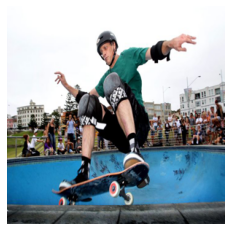


a man player a a a a a a.




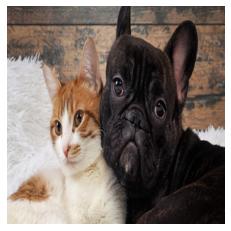


a cat cat on on of of of.




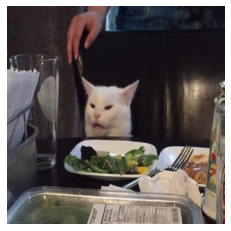


a person sitting at at at on a on.




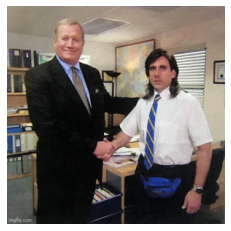


a man standing people standing are around a a.




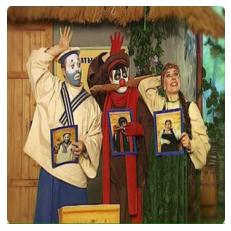


a group of people are a on a.




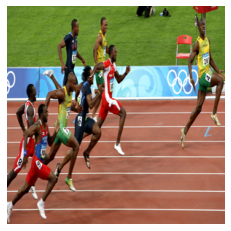


a man of a a a a a.




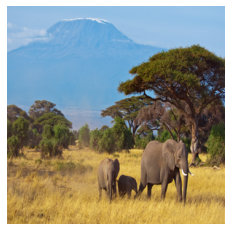


a elephant walking walking walking a in in.




In [ ]:
decoder.load_state_dict(torch.load(f'best_{type(decoder).__name__}_by_train_loss.pt'))

# skateboarder
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# cat and dog
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

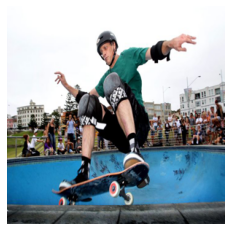


a man in a a a a a.




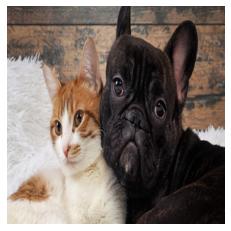


a dog of on on a a a.




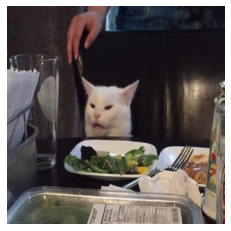


a man sitting a a a a a a a.




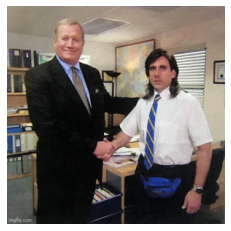


a man standing standing standing standing a a a.




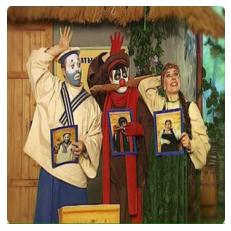


a group standing standing a a a a.




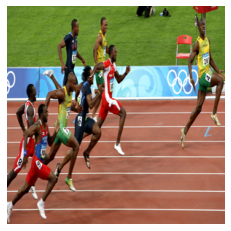


a man holding a tennis a a.




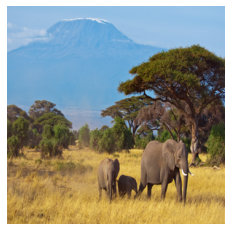


a people standing standing standing a a a.




In [ ]:
decoder.load_state_dict(torch.load(f'best_{type(decoder).__name__}_by_valid_loss.pt'))

# skateboarder
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# cat and dog
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

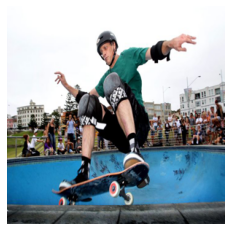


a to of a a a a a.




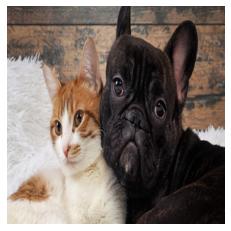


a to of a a a a a.




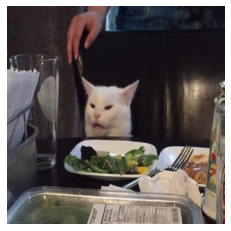


a to of a a a a a a a.




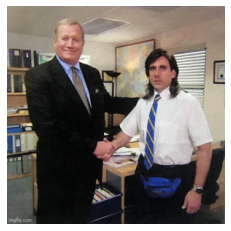


a to of a a a a a.




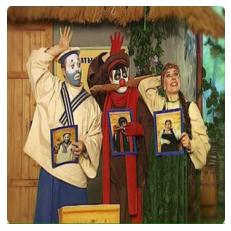


a to of a a a a a.




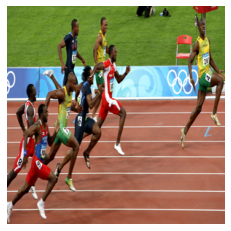


a to of a a a a a.




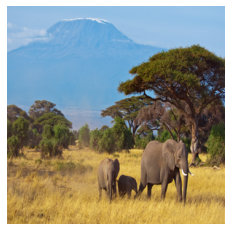


a to a a a a a.




In [ ]:
decoder.load_state_dict(torch.load(f'best_{type(decoder).__name__}_by_bleu.pt'))

# skateboarder
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# cat and dog
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# cat at restaurant 
!wget https://64.media.tumblr.com/30243eb75aa86ee15c7f7f40923b148e/tumblr_pak3z2ET3g1r9qwkso1_500.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# office handshake
!wget https://i.pinimg.com/564x/4f/a3/78/4fa3782e5d7c9276d00819a65a0cc83c.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# fools village
!wget https://do-slez.com/uploads/posts/2019-11/1574835807_1488781705_cqjebm4ueaamb7f.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# sprinters
!wget https://d2r55xnwy6nx47.cloudfront.net/uploads/2019/04/Bolt_2880x1620_Lede.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

# elephants
!wget https://cdn.britannica.com/30/65330-050-E723BBB6/African-elephants-area-Tanzania-Mount-Kilimanjaro.jpg -O img.jpg -q
img = Image.fromarray(plt.imread('img.jpg'))
img = np.array(img.resize((299, 299))).astype('float32') / 255.

plt.imshow(img)
plt.axis('off')
plt.show()
print()

caption = generate_caption_2(img)
print(' '.join(caption) + '.')

print('\n')

В данном случае ситуация похожа на ту, которая наблюдалась у базовой модели. Самое высокое значение BLEU было достигнуто на второй эпохе, и модель с соответствующими параметрами сгенерировала одинаковые (и совершенно бессмысленные) описания для всех картинок. Оставшиеся же две модели оказались довольно близки по качеству. Тем не менее, нужно отметить, что результаты, показанные ими, кажутся лучше, чем у базовой модели — теперь, помимо объекта, изображённого на картинке, сеть также иногда неплохо определяла положение этого объекта — "sitting", "standing", "walking" и т.д. Хотя, до более-менее приличных описаний модель всё ещё далека.

## Заключение

В ходе работы было протестировано 3 различных вариации модели, каждая из которых рассматривалась с 3-мя вариантами параметров. Следует отметить, что применение как self-attention, так и visual attention благотворно сказалось на показателях модели, хотя, на мой взгляд, self-attention и оказался полезнее. Его применение позволило строить более соответствующие картинкам и адекватные по конструкции описания при чуть больших затратах времени на обучение по сравнению с базовой моделью. Сеть с применением visual attention пришлось обучать гораздо дольше и, хоть она и дала прирост в качестве относительно базовой модели, каких-то прорывных изменений не произошло. 

В целом же, качество генерируемых описаний осталось, на мой взгляд, достаточно низким. Возможно, какие-либо архитектурные решения помогли бы улучшить ситуацию — например, другая структура attention, использование трансформеров вместо RNN, использование другой свёрточной сети в качестве энкодера или же обучение/fine-tuning всей модели целиком (энкодер + декодер) вместо применения предобученных сетей. Также, вероятно, есть лучшие гиперпараметры в сравнении с теми, что были подобраны в данной работе. Кроме того, рассмотренные модели генерировали описания по "жадному" принципу, предсказывая на каждом этапе слово, получившее наибольшую вероятность. В качестве альтернативы можно было бы попробовать использовать beam search. 

Таким образом, существует ещё довольно широкое поле для экспериментов и, быть может, какой-либо подход позволит получить хорошее качество описаний, но, если выбирать из того, что есть, то, думаю, оптимальным вариантом будет модель с self-attention.